# osucad-cursor-path

This is an attempt at predicting the path a player's cursor would take on an osu beatmap. I never actually touched tensorflow before until like 3 days ago so please excuse the mess that I've made here.
This is based on [OsuLearn](https://github.com/GuiBrandt/OsuLearn/), without this repository none of this would have been possible.

In [1]:
import os
import re
import math
import glob
from importlib import reload

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

2022-10-31 20:12:37.484190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 20:12:37.609534: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 20:12:38.081420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/marvin/miniconda3/lib/
2022-10-31 20:12:38.081477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: 

## Objective

The objective is to create a model that can generate a convincing replay of a beatmap, for the collaborative beatmap editor [osucad](https://github.com/minetoblend/osu-cad).

## Dataset
### Input Data

The input dataset is made up of 6 second segments, of samples taken from a beatmap at 30 frames per second. Each sample is an array of the following values:

| Name       | Description                                                                                                                                                                                                                                                                                                                                                                                                         |
|------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| x          | The x coordinate of the currently active hitobject, with the range mapped from `[0, 512]` to `[-0.5, 0.5]`<br>If the hitobject is a slider, and the time falls between it's start and end time, the current position of the sliderball is being used, otherwise the slider's start position will be used.<br> If the object is a spinner, the center of the playfield is being assumed as the hitobject's position. |
| y          | The y coordinate of the currently active hitobject, with the range mapped from `[0, 384]` to `[-0.5, 0.5]`<br>If the hitobject is a slider, and the time falls between it's start and end time, the current position of the sliderball is being used, otherwise the slider's start position will be used.<br> If the object is a spinner, the center of the playfield is being assumed as the hitobject's position. |
| visible    | If in-between the start and end time of the current hitobject, holds a value of 1. If the frame is in-between hitobjects, it holds the visibility of the visibility of the hitobejct, fading in from 0 over the span of the beatma's preempt time (based on approach rate).                                                                                                                                         |
| is_circle  | Whether or not the currently active hitobject is a circle (0 or 1)                                                                                                                                                                                                                                                                                                                                                  |
| is_slider  | Whether or not the currently active hitobject is a slider (0 or 1)                                                                                                                                                                                                                                                                                                                                                  |
| is_spinner | Whether or not the currently active hitobject is a spinner (0 or 1)                                                                                                                                                                                                                                                                                                                                                 |

The active hitobject for each frame is being decided by 2 factors:
- If the current time falls in-between the start and end time of a hitobject, that object is selected as the currently active object.
- Otherwise, the first hitobject that is currently visible (it is assumed, that a hitobject starts being visible at preempt duration subtracted from its start time) is selected.

In [2]:
input_data = json.load(open('dataset/input.json'))

X = np.array(input_data)
X.shape

(5578, 180, 6)

### Target Data

The target data is a list of 6 second segments taken from replays at 30 fps, each replay matching the beatmap and timestamp of the batmap from the input dataset. Each frame is an array containing an x/y coordinate pair, mapped form the osu playfield size, to a `[-0.5, 0.5]` range.

In [3]:
target_data = json.load(open('dataset/target.json'))

Y = np.array(target_data)
Y.shape

(5578, 180, 2)

## Model
This is the part where I actually have very little idea what I'm, I mostly arrived at the current model through trial and error.
The model is pretty simple so I won't bother explaining stuff here.

In [4]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, GaussianNoise, Bidirectional, RepeatVector, ConvLSTM1D, ConvLSTM2D, GRU, TimeDistributed, Flatten

map_input = Input(shape=X.shape[1:], name='map_info')

model = Sequential([
    Bidirectional(LSTM(16, return_sequences=True), input_shape=X.shape[1:]),
    LSTM(16, return_sequences=True),
    Dense(16, activation='linear'),
    Dense(Y.shape[2], activation='linear', name='position')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
model.summary()

try:
    model.load_weights("./data/model.h5")
except Exception as e:
    print()
    print("Failed to load weights: ", e)


2022-10-31 20:12:43.474361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 20:12:43.478870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 20:12:43.479061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 20:12:43.479620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 180, 32)          2944      
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 180, 16)           3136      
                                                                 
 dense (Dense)               (None, 180, 16)           272       
                                                                 
 position (Dense)            (None, 180, 2)            34        
                                                                 
Total params: 6,386
Trainable params: 6,386
Non-trainable params: 0
_________________________________________________________________

Failed to load weights:  [Errno 2] Unable to open file (unable to open file: name = './data/model.h5', errno = 2, error

## Training
I found doing 48 iterations with 16 epochs each gives me pretty good results. Beyond that point there's not really much change happening.

In [5]:
from random import randint
from sklearn.model_selection import train_test_split

ITERATIONS = 48
EPOCHS = 16

try:
    loss
except NameError:
    loss = []

for i in range(ITERATIONS):
    print("Iteration #%d" % (i + 1))
    print("_" * 80)
    print()
    X_train, X_tecst, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=randint(0, 100))
    h = model.fit(X_train, y_train, batch_size=1024, epochs=EPOCHS, verbose=1)
    loss += h.history['loss']
    print()

model.save("./data/model.h5")


Iteration #1
________________________________________________________________________________

Epoch 1/16


2022-10-31 20:12:47.859754: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/4 [======>.......................] - ETA: 10s - loss: 0.2216

2022-10-31 20:12:48.436258: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4/4 [==============================] - 4s 28ms/step - loss: 0.2117
Epoch 2/16
4/4 [==============================] - 0s 30ms/step - loss: 0.1916
Epoch 3/16
4/4 [==============================] - 0s 23ms/step - loss: 0.1761
Epoch 4/16
4/4 [==============================] - 0s 23ms/step - loss: 0.1618
Epoch 5/16
4/4 [==============================] - 0s 23ms/step - loss: 0.1474
Epoch 6/16
4/4 [==============================] - 0s 23ms/step - loss: 0.1324
Epoch 7/16
4/4 [==============================] - 0s 23ms/step - loss: 0.1188
Epoch 8/16
4/4 [==============================] - 0s 24ms/step - loss: 0.1102
Epoch 9/16
4/4 [==============================] - 0s 28ms/step - loss: 0.1016
Epoch 10/16
4/4 [==============================] - 0s 28ms/step - loss: 0.0945
Epoch 11/16
4/4 [==============================] - 0s 21ms/step - loss: 0.0904
Epoch 12/16
4/4 [==============================] - 0s 20ms/step - loss: 0.0874
Epoch 13/16
4/4 [==============================] - 0s 20ms/step - loss: 

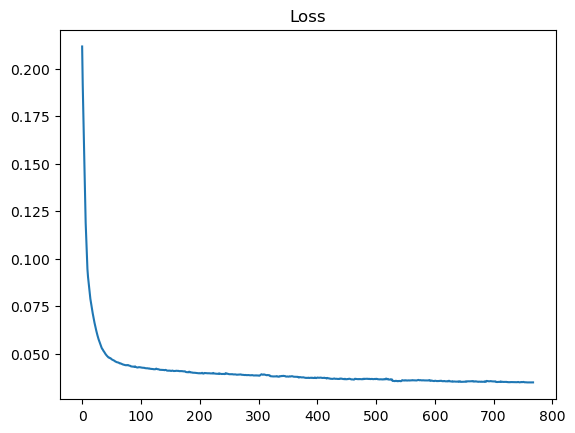

In [6]:
%matplotlib inline

plt.plot(loss)
plt.title("Loss")
plt.show()

In [7]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

def plot_error_colormapped_axis_position(beatmap, target, predicted, axis):
    fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

    fig.gca().plot(beatmap[:,axis], color='yellow', alpha=0.1, label='beatmap')
    fig.gca().plot(target[:,axis], color='black', alpha=0.4, label='target')
    cmap = LinearSegmentedColormap.from_list("", [(0, 0.8, 0), (0.8, 0, 0)])
    time = np.linspace(0, len(predicted), len(predicted))
    pos = predicted[:,axis]
    diff = np.absolute(target[:,axis] - predicted[:,axis])
    points = np.array([time, pos]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-2],points[1:-1], points[2:]], axis=1)

    norm = plt.Normalize(diff.min(), diff.max())

    lc = LineCollection(segments, cmap=cmap, norm=norm, label='predicted')
    lc.set_array(diff)
    fig.gca().add_collection(lc)
    fig.gca().autoscale()
    fig.gca().legend()

def plot_2d_graph(beatmap, target, predicted):
    fig = plt.figure(figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

    plt.gca().plot(beatmap[:,0], beatmap[:, 1], color='yellow', alpha=0.1, label='beatmap', linestyle='--')
    plt.gca().plot(target[:,0], target[:, 1], color='black', alpha=0.1, label='target', linestyle='--')
    plt.gca().plot(predicted[:,0], predicted[:, 1], color='black', alpha=1, label='predicted')

    fig.gca().autoscale()
    fig.gca().legend()

def plot_info(beatmap, target, predicted):
    %matplotlib inline

    plot_error_colormapped_axis_position(beatmap, target, predicted, 0)
    plt.title("X")
    plt.show()

    plot_error_colormapped_axis_position(beatmap, target, predicted, 1)
    plt.title("Y")
    plt.show()

    plot_2d_graph(beatmap, target, predicted)
    plt.title("Playfield")
    plt.show()


175/175 [==============================] - 1s 8ms/step
Batch 0


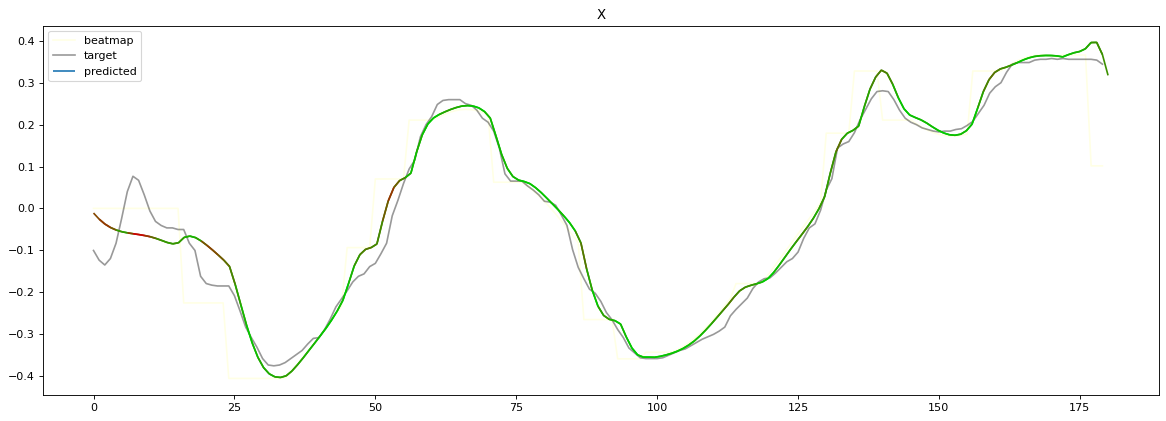

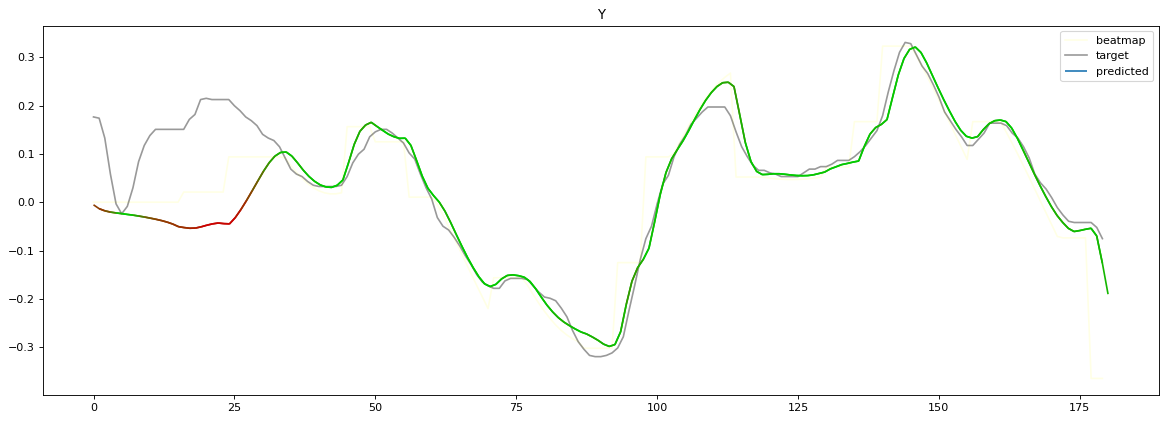

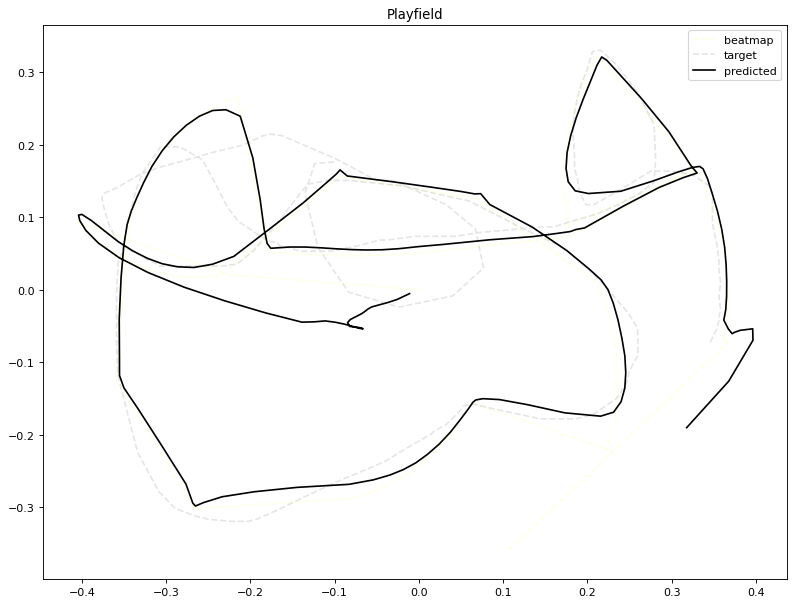




Batch 1


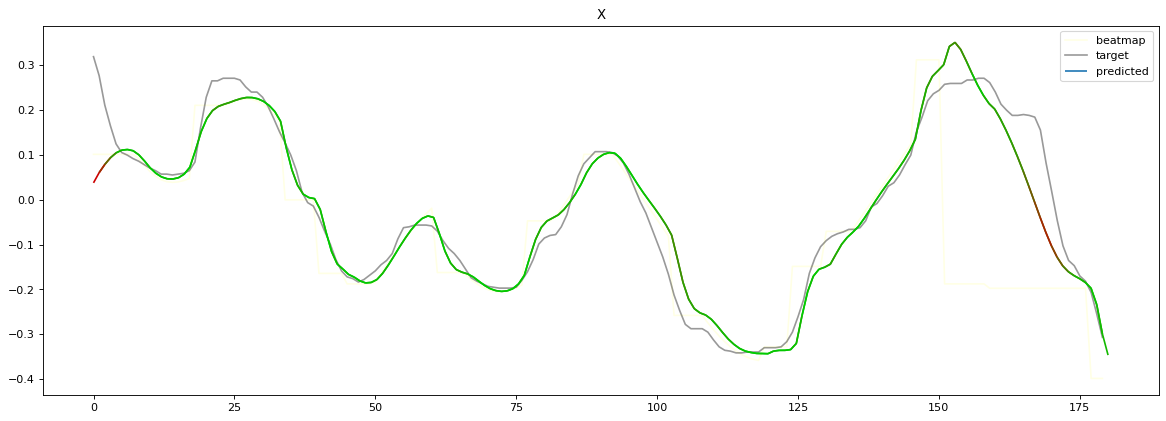

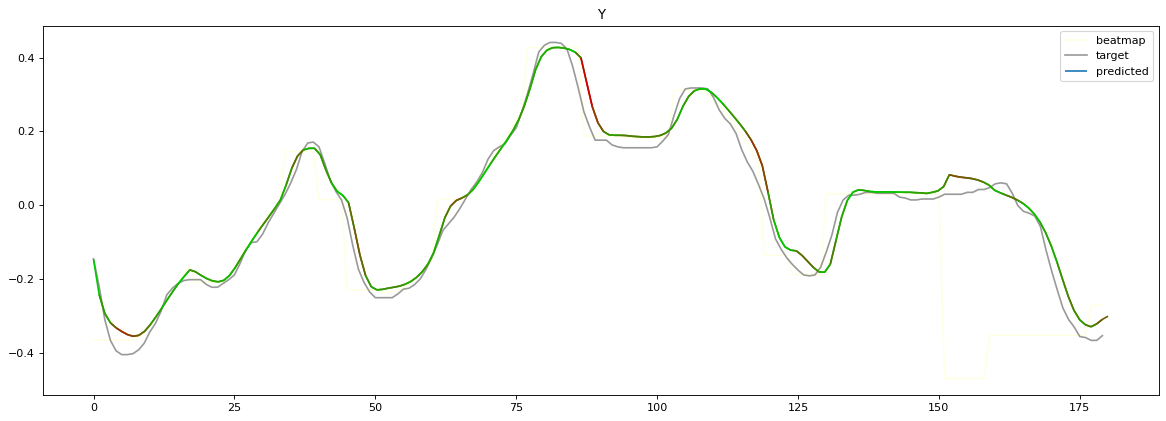

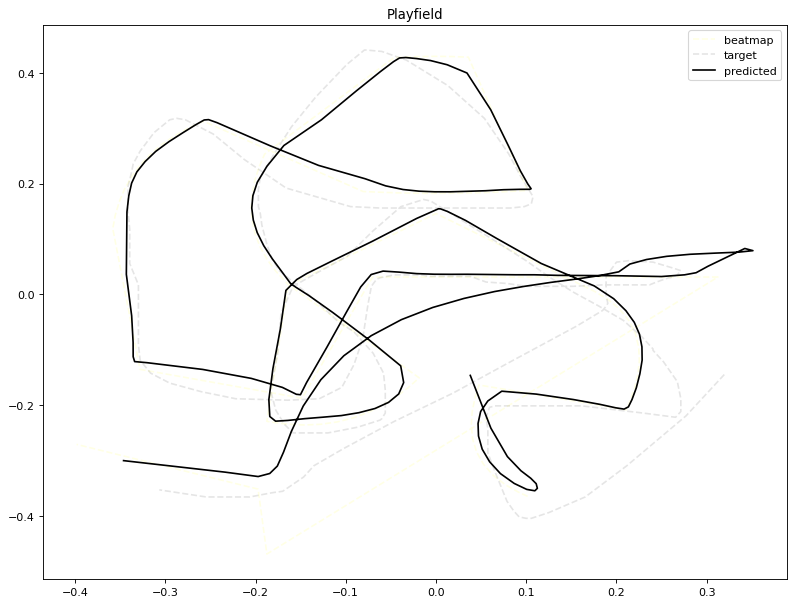




Batch 2


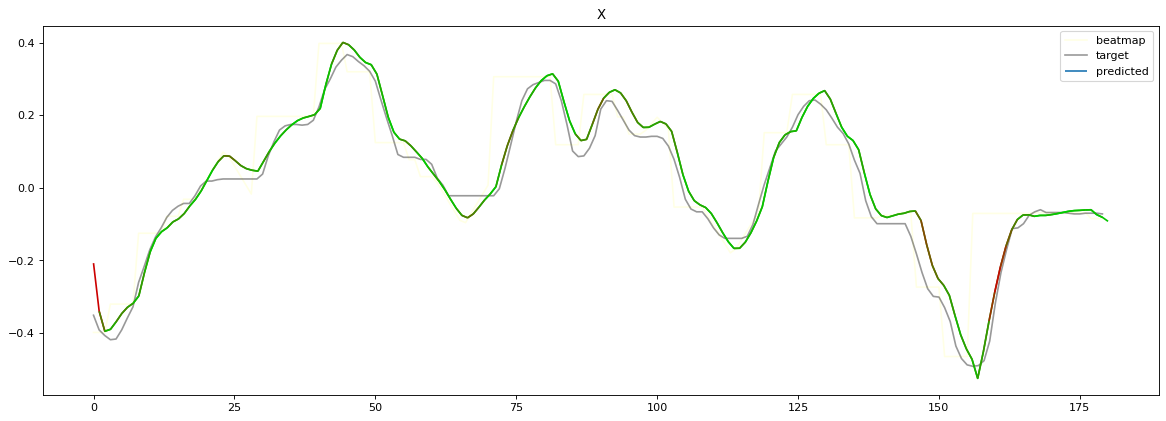

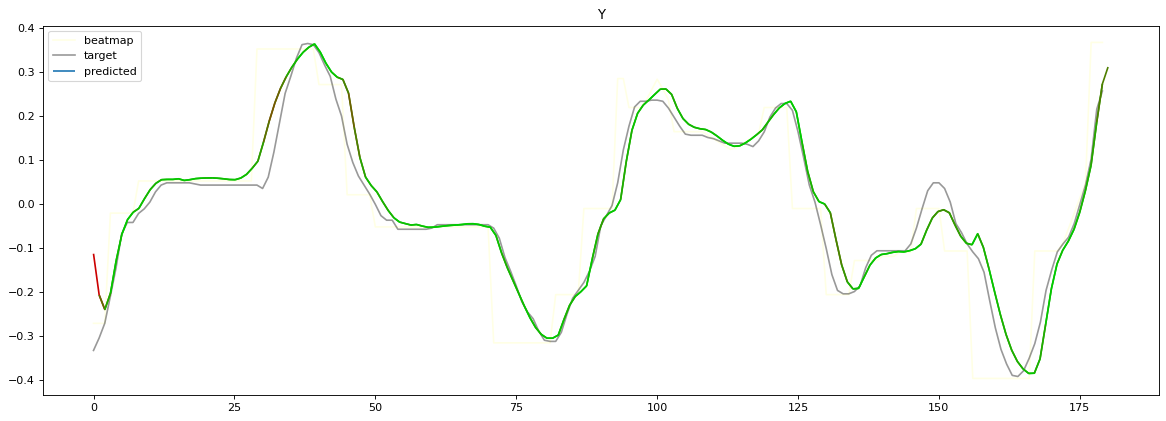

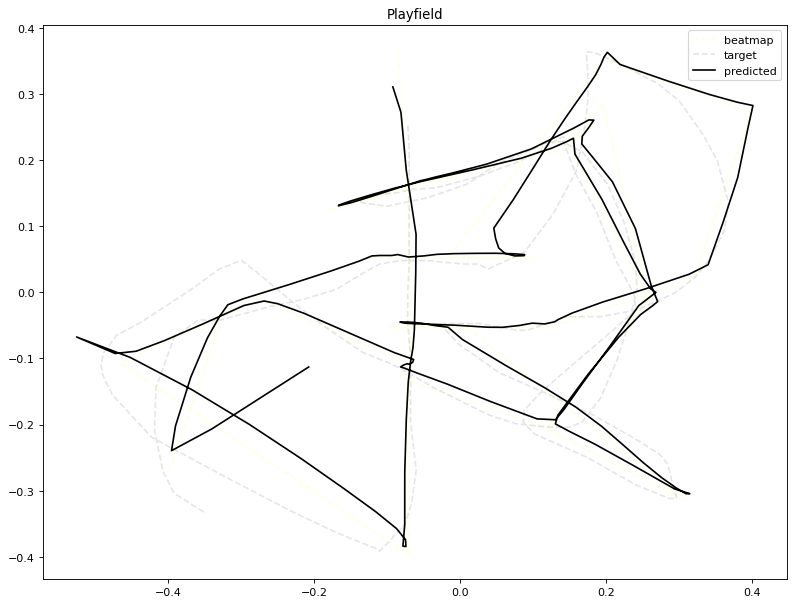




Batch 3


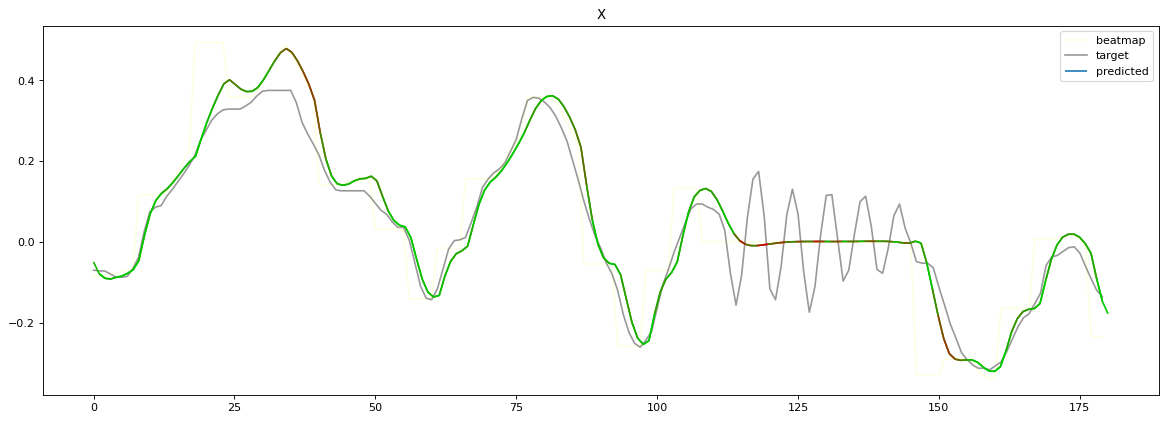

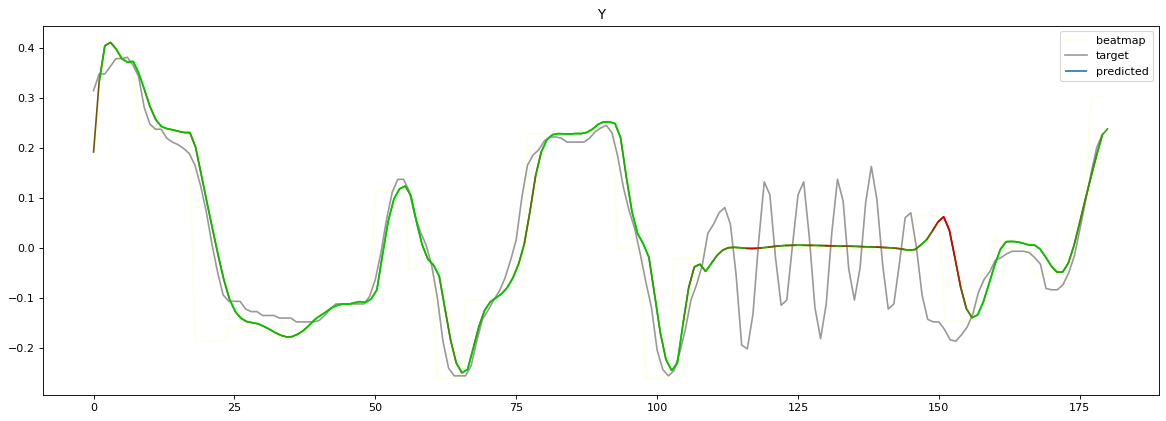

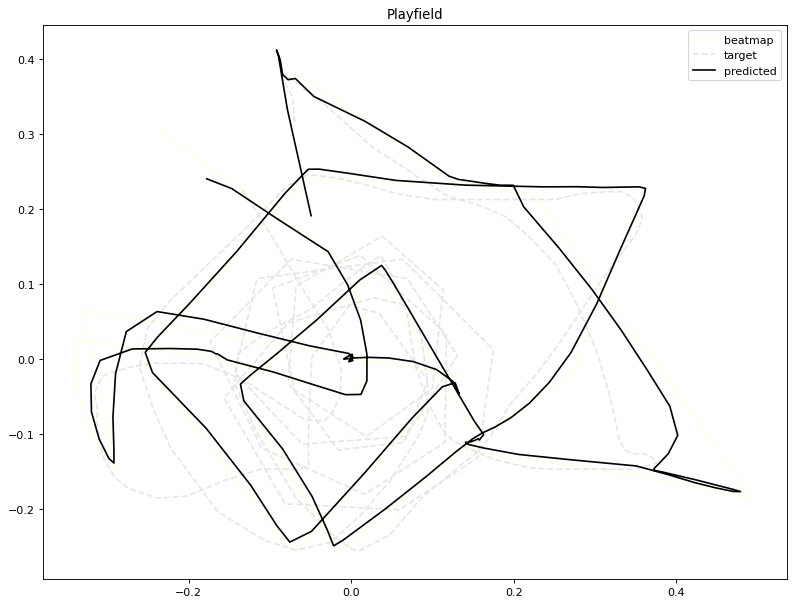

In [9]:
predicted_pos = model.predict(X)
import random

for i in range(4):
    rand_idx = random.randint(0, len(X)-1)
    print("Batch", i)
    plot_info(X[i], Y[i], predicted_pos[i])
    print()
    print()
    print()


## Results
I think the results so far are pretty good given the simplicity of the model. It creates pretty convincing gameplay in most cases, as long as the beatmap difficulty is within reasonable limits. Since the model needs to run warm for a few frames each time, it is advised to splice together the latter halves of each generated segment when trying to create longer snippets of gameplay.
The generated gameplay can be viewed interactively over at the [osucad](https://github.com/minetoblend/osu-cad) repository, where it can be turned on under the `View` menu in the menubar.

## Known Issues

### Needs to "run warm"
The cursor currently starts in the center of the playfield at the beginning of each snippet, and only starts following the hitobjects atfer "running warm" for a few frames.

### Hitting the hitobjects
The model is not being trained on if the objects are actually being hit, doing that is out of scope for the time being. The training data is made up exclusively of scores with 100% accuracy, to make the bot follow the map as well as possible, but in some cases it fails to actually hit the hitobjects. Especially during very quick jumps.

### No knowledge on future hitobjects
The input data only contains the current or next visible hitobject, this means there is no differentiation between i.e. a jump that leads into a single circle, or a jump that leads into a stream.

### Quick snapping on slow segments
The current model snaps really quickly to objects currently, even in calm/easy sections. This leads to quite unnatural looking gameplay in those sections. I think this could be fixed by adjusting the dataset to favor easier maps over harder maps. Perhaps some information like how many objects are currently visible on screen might also work here.

### Spinners
The model just holds still on spinners, this is probably also an issue with there being barely any spinners in the dataset, so it never gets to learn it.
Also, unlike the replay in regular sections which is fairly predictable from the hitobjects themselves, spinning is very chaotic and can't be directly trained using replays. An approach using a GAN might be an option to achieve this.

### Breaks
Same as with spinners, the model just sits still. Also possible that an approach using a GAN model could solve this.

## Future
I got 2 ideas for improving this model in the future
1. I want to change the data being fed to the model to better reflect the information that an actual player would have when playing the map. This mainly means having knowledge about the hitobject positions at multiple points in time in the future relative to the current time. I am not yet sure if that can be done inside the model itself or if needs to be done as part of the actual dataset.
2. Transforming this into a GAN, I believe that this could solve a lot of the problems the current model has, as instead of trying to mimic an existing gameplay each time, it would be trained to create gameplay that actually *looks* like real gameplay.